# Hierarchical Clustering Model for Images

https://ieeexplore.ieee.org/document/8285868

## Load functions

In [ ]:
from skimage.feature import local_binary_pattern
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, metrics
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy import stats
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load Dataset

In [ ]:
# Assign a label number to each of the categories:
# face - 0      cat - 1      dog - 2       wild - 3
# sushi - 4     tacos - 5    takoyaki - 6  tiramisu - 7
# tuna - 8      waffles - 9  

labels_dict = {0:"faces",
               1:"cat",
               2:"dog",
               3:"wild",
               4:"sushi",
               5:"tacos",
               6:"takoyaki",
               7:"tiramisu",
               8:"tuna_tartare",
               9:"waffles"
               }

In [ ]:
import os
import cv2
from skimage.transform import rescale

def load_images(path_spec, label):
  print(f"Loading {path_spec} images...")

  path_train = '/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/ML Final Project Data/Processed/Train/' + path_spec + '/'
  path_val = '/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/ML Final Project Data/Processed/Val/' + path_spec + '/'
  img_arr = []

  # NOTE: For clustering we don't really need train/test splits.
  # This version of the data loading appends both sets together.

  # Loop through the training set
  for filename in os.listdir(path_train):
    # We only need to keep 1 color channel, since the images have been grayscaled
    img = cv2.imread(path_train + filename)[:,:,0]

    # Downscale if we run out of of RAM
    # Shouldn't be necessary, since images are preprocessed to be 128x128
    #img = rescale(img, 0.5, anti_aliasing=True)

    # Data is formatted as [image,label]
    img_arr.append([img,label]) 

  # Loop through the validation set
  for filename in os.listdir(path_val):
    # We only need to keep 1 color channel, since the images have been grayscaled
    img = cv2.imread(path_val + filename)[:,:,0]

    # Downscale if we run out of of RAM
    # Shouldn't be necessary, since images are preprocessed to be 128x128
    #img = rescale(img, 0.5, anti_aliasing=True)

    # Data is formatted as [image,label]
    img_arr.append([img,label]) 

  return img_arr

dat_arr = []
for l in list(labels_dict.keys()):
  dat_arr.append(load_images(labels_dict[l], l))

print("Loading done.")

Loading faces images...
Loading cat images...
Loading dog images...
Loading wild images...
Loading sushi images...
Loading tacos images...
Loading takoyaki images...
Loading tiramisu images...
Loading tuna_tartare images...
Loading waffles images...
Loading done.


faces dimensions [num examples, 2]:  (1125, 2)
cat dimensions [num examples, 2]:  (1125, 2)
dog dimensions [num examples, 2]:  (1125, 2)
wild dimensions [num examples, 2]:  (1125, 2)
sushi dimensions [num examples, 2]:  (1125, 2)
tacos dimensions [num examples, 2]:  (1125, 2)
takoyaki dimensions [num examples, 2]:  (1125, 2)
tiramisu dimensions [num examples, 2]:  (1125, 2)
tuna_tartare dimensions [num examples, 2]:  (1125, 2)
waffles dimensions [num examples, 2]:  (1124, 2)


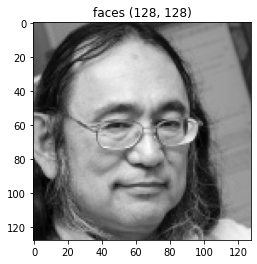

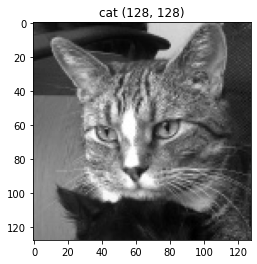

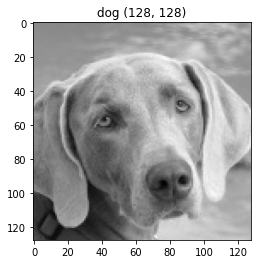

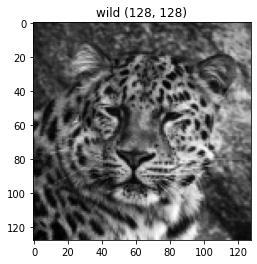

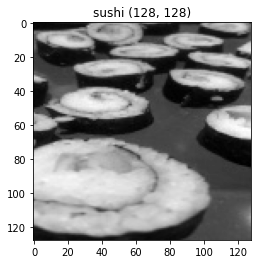

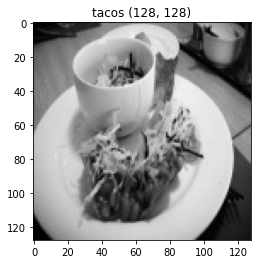

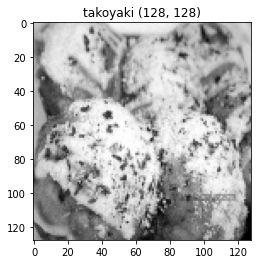

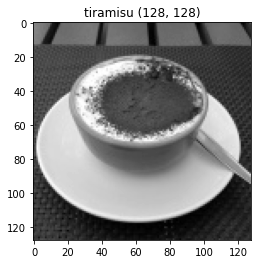

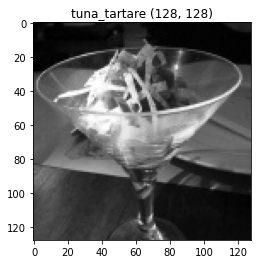

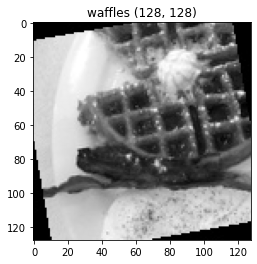

In [ ]:
# Show an example of each
for l in list(labels_dict.keys()):
  name = labels_dict[l]
  print(f"{name} dimensions [num examples, 2]: ", np.shape(dat_arr[l]))
  img = dat_arr[l][0][0]
  plt.figure()
  plt.imshow(img, cmap="gray")
  plt.title(name+" "+str(np.shape(img)))

(11249, 2)
Input size:  (11249,)
Label size:  (11249,)
Image dimensions:  (128, 128)


Text(0.5, 1.0, 'Label tacos, 5')

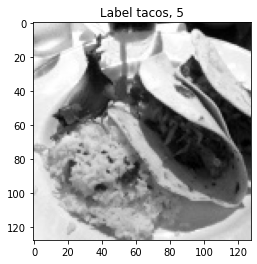

In [ ]:
# Concatenate together
all_data = dat_arr[0]

for i in range(1,len(dat_arr)):
  all_data = np.concatenate((all_data, dat_arr[i]))

print(np.shape(all_data))

# Shuffle the data
np.random.seed(42) 
np.random.shuffle(all_data)
# Split images and labels apart
inputs = all_data[:,0]
y_labels = all_data[:,1]

print("Input size: ", np.shape(inputs))
print("Label size: ", np.shape(y_labels))

# Show an example
img = inputs[0]
print("Image dimensions: ", np.shape(img))
plt.figure()
plt.imshow(img, cmap="gray")
plt.title(f"Label {labels_dict[y_labels[0]]}, {y_labels[0]}")

## Compute Local Binary Patterns using the sklearn function

Local Binary Pattern computation done.
(11249, 16384)


/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


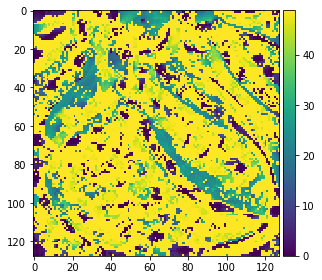

In [ ]:
lbps = []
radius = 6
n_points = 8*radius
METHOD = 'uniform'

# Image resolution
res = np.shape(img)[0]
for i in range(len(inputs)):
    lbps.append(local_binary_pattern(inputs[i], n_points, radius, METHOD).reshape(res*res))

lbps = np.array(lbps)
print("Local Binary Pattern computation done.")
print(np.shape(lbps))

lbp_example = lbps[0].reshape(res,res)
io.imshow(lbp_example, )

## Clustering

## Visualization - Dendrogram

The dendrogram will help us decide what distance threshold to use. Ideally we want just enough clusters to perform our classifications.

In [ ]:
d = linkage(lbps, method='ward', metric='euclidean')
plt.figure(figsize=(10, 8))  
plt.title("Hierarchy Dendrogram",{'fontsize': 18})  
dendrogram(d, no_labels=True)
plt.show

In [ ]:
# Documentation link: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
# Can also use a memory='C:\\' to cache the tree somewhere, or we can pickle the model for later
# Prefer to use distance_threshold instead of n_clusters, as this will produce a dendrogram
# Affinity - I think the distance metric makes the most sense as euclidean

cluster_model = cluster.AgglomerativeClustering(n_clusters = None, distance_threshold = 7000, affinity ='euclidean', linkage='ward')
clusters = cluster_model.fit(lbps)
print("Clustering done")

# Convert cluster classifications to numpy array for easier computation
l = np.array(clusters.labels_)
cluster_classes = np.unique(l)

print(cluster_classes)

# Cluster classifications
print(clusters.labels_)

Clustering done
[ 0  1  2  3  4  5  6  7  8  9 10 11]
[ 8  1 11 ...  1 10  4]


In [ ]:
# Save the model
fname = "/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/cluster_ward_linkage_7000.model"
pickle.dump(clusters, open(fname, "wb"))

In [ ]:
# Save the ground truth labels order (since it is randomized, we want this to be consistent with our clustering run)
labels_fname = "/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/clustering_ground_truth.npy"
np.save(labels_fname,y_labels)

## Purity Analysis

In [ ]:
# Load in the model and data
model_threshold = 5000
#model_threshold = 6000
#model_threshold = 7000
cluster_fname = "/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/cluster_ward_linkage_"+str(model_threshold)+".model"
labels_fname = "/content/drive/MyDrive/!Y4_ML_EN.601.475/ML Final Project/clustering_ground_truth.npy"

loaded_clusters = pickle.load(open(cluster_fname, "rb"))
loaded_labels = np.load(labels_fname, allow_pickle=True)

In [ ]:
# Analyze the cluster assignment for Purity
cluster_assignment = {}
y_labels = loaded_labels
l = loaded_clusters.labels_
cluster_classes = np.unique(l)
# First, gather all of the members of each cluster, for n clusters
# Identify the corresponding category labels
# Find the mode, and assign that as the cluster label
for i in cluster_classes:
    # Select members of the ith class, and their corresponding y_label
    labels = y_labels[np.where(l == i)]
    # Take the mode of the y_label of the ith class
    
    cluster_assignment[i] = stats.mode(labels).mode[0]

print(cluster_assignment)

{0: 4, 1: 1, 2: 3, 3: 2, 4: 8, 5: 5, 6: 1, 7: 0, 8: 2, 9: 0, 10: 0, 11: 1, 12: 0, 13: 8, 14: 9, 15: 3, 16: 1, 17: 2, 18: 4, 19: 8, 20: 0, 21: 8, 22: 0, 23: 1, 24: 2}


In [ ]:
# Deep copy the cluster classifications
y_pred = np.copy(l)

# We will now go through and assign the category label for each cluster classification
for i in cluster_classes:
    # cluster_assignment is a dictionary, with the cluster as the key and the associated category as a value
    # y_pred currently is a copy of cluster membership labels l. modify the entries so that these
    # cluster memberships are now category labels.
    y_pred[np.where(l==i)] = cluster_assignment[i]

print(y_pred)
print(y_labels)

[2 8 5 ... 8 0 3]
[5 6 5 ... 4 0 6]


In [ ]:
def purity_acc(pred, truth):
    return np.sum(pred == truth)/len(pred)

purity = purity_acc(y_pred, y_labels)
print("Purity score: ", purity)

Purity score:  0.25611165436927724


## Homogeneity and Completeness Scores

In [ ]:
# Function inputs:
# y_labels - The ground truth categorical labels
# cluster.labels_ - the cluster classifications
homogeneity, completeness, v_measure = metrics.homogeneity_completeness_v_measure(y_labels, l, beta=1.0)
print("Homogeneity: ", homogeneity)
print("Completeness: ", completeness)
print("V Measure: ", v_measure)

Homogeneity:  0.1325909267976728
Completeness:  0.11186325059481093
V Measure:  0.12134832162964174


## Cluster Analysis

### Plotting cluster pie-charts

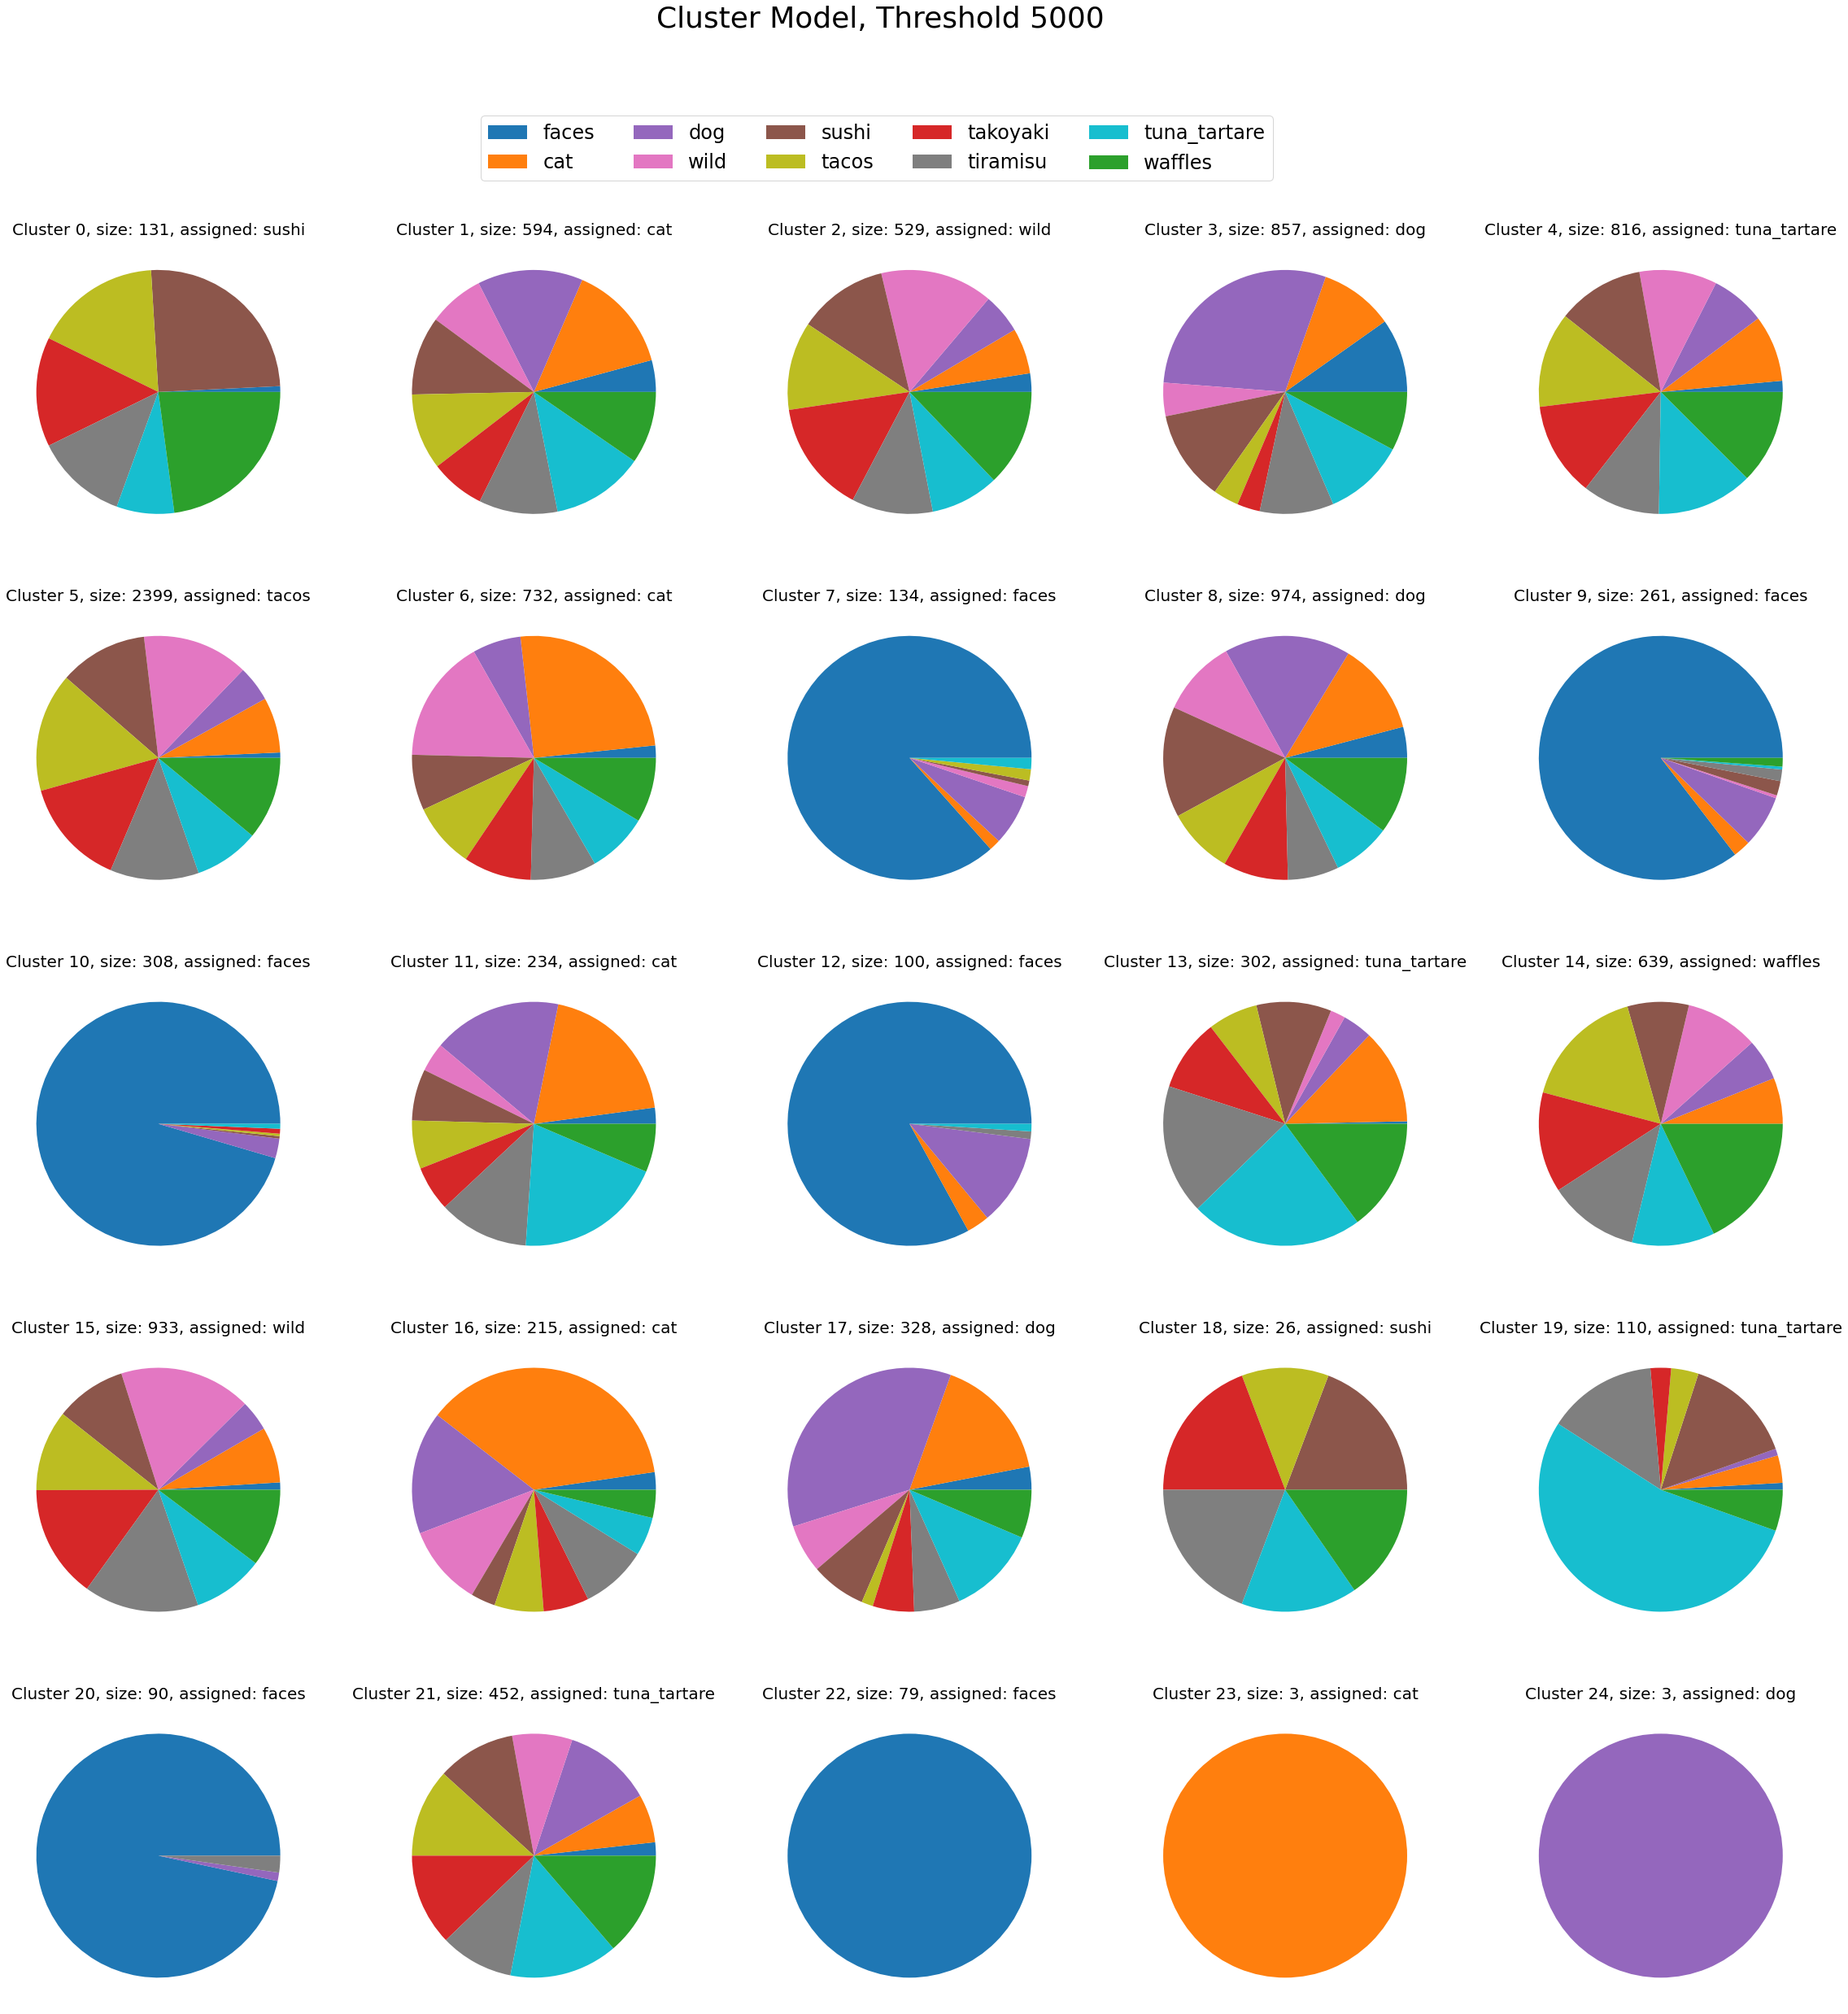

In [ ]:
# Dictionary to store cluster member distributions for visualizing the population
# within each cluster
cluster_membs = {}
cluster_membs_dists = {}
y_labels_unique = np.unique(y_labels)
# 10 colors for 10 categories
colors = {"tab:red","tab:blue","tab:green","tab:brown","tab:orange","tab:pink","tab:purple","tab:olive","tab:cyan","tab:gray"}
for i in cluster_classes:
  membs = np.where(l==i)
  cluster_membs[i] = y_labels[membs]
  cluster_distribution = []
  for j in y_labels_unique:
    cluster_distribution.append(np.sum(cluster_membs[i] == j))
  cluster_membs_dists[i] = cluster_distribution

# Plot pie-charts to show cluster distributions
subplots_rows = int(np.ceil(len(cluster_classes)/5))
fig,ax = plt.subplots(subplots_rows,5,figsize=[40,8*subplots_rows])
plot_num = 0
for i in range(subplots_rows):
  for j in range(5):
    if plot_num > len(cluster_classes)-1:
      break

    # Calculate the size of the cluster
    cluster_size = len(cluster_membs[plot_num])
    # Retrieve the category assigned to the cluster
    cluster_mode = labels_dict[cluster_assignment[plot_num]]
    ax[i,j].pie(cluster_membs_dists[plot_num], colors=colors);
    ax[i,j].set_title(f"Cluster {plot_num}, size: {cluster_size}, assigned: {cluster_mode}", fontdict={'fontsize':20});
    plot_num += 1

fig.legend(list(labels_dict.values()),loc=(0.26,0.91),ncol=5, fontsize=24)
fig.suptitle(f"Cluster Model, Threshold {model_threshold}",fontsize=36);


### Percentage properly labeled

Cluster 0, assigned: 4 sushi, num correct: 33
Cluster 1, assigned: 1 cat, num correct: 85
Cluster 2, assigned: 3 wild, num correct: 79
Cluster 3, assigned: 2 dog, num correct: 250
Cluster 4, assigned: 8 tuna_tartare, num correct: 104
Cluster 5, assigned: 5 tacos, num correct: 378
Cluster 6, assigned: 1 cat, num correct: 184
Cluster 7, assigned: 0 faces, num correct: 116
Cluster 8, assigned: 2 dog, num correct: 163
Cluster 9, assigned: 0 faces, num correct: 223
Cluster 10, assigned: 0 faces, num correct: 294
Cluster 11, assigned: 1 cat, num correct: 46
Cluster 12, assigned: 0 faces, num correct: 83
Cluster 13, assigned: 8 tuna_tartare, num correct: 69
Cluster 14, assigned: 9 waffles, num correct: 114
Cluster 15, assigned: 3 wild, num correct: 163
Cluster 16, assigned: 1 cat, num correct: 80
Cluster 17, assigned: 2 dog, num correct: 116
Cluster 18, assigned: 4 sushi, num correct: 5
Cluster 19, assigned: 8 tuna_tartare, num correct: 59
Cluster 20, assigned: 0 faces, num correct: 87
Cluste

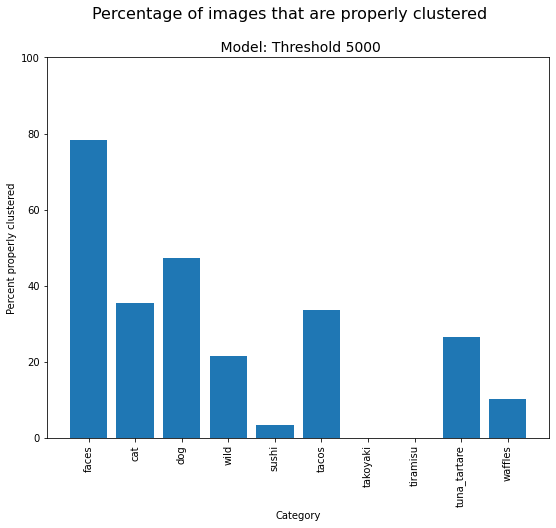

In [ ]:
# Tally up the number of items properly clustered
num_properly_clustered = np.zeros(10)
# For each cluster
for i in cluster_classes:
  # Loop through each category
  for j in range(10):
    # If the current category being considered is the same as
    # the category assigned to the cluster
    if j == cluster_assignment[i]:
      # Tally up the members of the cluster that are properly
      # assigned to the category
      num_correct = sum(cluster_membs[i]==j)
      num_properly_clustered[j] += num_correct
  print(f"Cluster {i}, assigned: {cluster_assignment[i]} {labels_dict[cluster_assignment[i]]}, num correct: {num_correct}")

percent_properly_clustered = np.zeros(10)
for k in range(10):
  percent_properly_clustered[k] = num_properly_clustered[k]/np.sum(y_labels==k) * 100

plt.figure(figsize=(9,7))
plt.bar(range(10),percent_properly_clustered)
plt.ylim(0,100)
plt.xticks(range(10), labels=list(labels_dict.values()),rotation="vertical");
plt.xlabel("Category")
plt.ylabel("Percent properly clustered")
plt.suptitle("Percentage of images that are properly clustered",fontsize=16);
plt.title(f" Model: Threshold {model_threshold}",fontsize=14);
print(percent_properly_clustered)